In [115]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import requests
from torch.autograd import Variable
import datetime

In [116]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length=5):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size * 3, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * 3, hidden_size * 2)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size * 1)
        self.fc2 = nn.Linear(hidden_size * 1, num_classes)
        # self.fc3 = nn.Linear(hidden_size * 1, hidden_size // 2)
        # self.fc4 = nn.Linear(hidden_size // 2, num_classes)



    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size * 3))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size * 3))

        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size * 3)
        out = self.fc(h_out)
        out = self.fc1(out)
        out = self.fc2(out)

        return out

In [117]:
seq_length = 64
lstm = LSTM(3, 3, 16, 1, seq_length)
lstm.load_state_dict(torch.load("models/energy_usage_predictor.pth"))

lstm.eval()


def sliding_windows(data, seq_length, first_sequence=True):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        if first_sequence:
            x.append(_x)
            first_sequence = False
        y.append(_y)

    return np.array(x), np.array(y)

# Get the last 12 points of 10 minute chunks (so if every 5 seconds, that is 2400) and predict what the prices will be
response = requests.get(f"http://144.39.204.242:11236/evr/leviton/evr?limit={seq_length * 100}")
usage = response.json()
ten_minute_averages = {"timestamp": [], "power": [], "isDay": [], "hour": []}
time_format = '%Y-%m-%dT%H:%M:%S.%fZ'
for i in range(0, len(usage['data']), 85):
    values = usage['data'][i:i+120]
    power = [value['power'] for value in values]
    ten_minute_averages["timestamp"].append(values[0]['timestamp'])
    ten_minute_averages["power"].append(np.average(power) * 1000)
    test_date = datetime.datetime.strptime(values[0]['timestamp'], time_format)
    test_date = test_date - datetime.timedelta(hours=6)
    isDay =  1 if test_date.hour >= 7 and test_date.hour <= 19 else 0 # From 7:00 AM to 7 PM is day
    hour = test_date.hour
    ten_minute_averages["isDay"].append(isDay)
    ten_minute_averages["hour"].append(hour)
df = pd.DataFrame(columns=["timestamp", "power", "isDay", "hour"])    
temp_df = pd.DataFrame(ten_minute_averages)
df = pd.concat([df, temp_df], ignore_index=True)
test_training_set = df.iloc[:, 1:5].values

sc = MinMaxScaler()
power = sc.fit_transform(test_training_set)
testNewX, testNewY = sliding_windows(power, seq_length)

tensorX = torch.Tensor(testNewX)

first_prediction = lstm(tensorX)

In [118]:
predictions = []
first_prediction = lstm(tensorX)

for i in range(len(testNewY)):
    tensorX = torch.Tensor(testNewX)
    first_prediction = lstm(tensorX)
    testNewX[0][0] = first_prediction.data.numpy()[0][0]
    testNewX = np.roll(testNewX, shift=-1)
    predictions.append(sc.inverse_transform(first_prediction.data.numpy())[0][0])

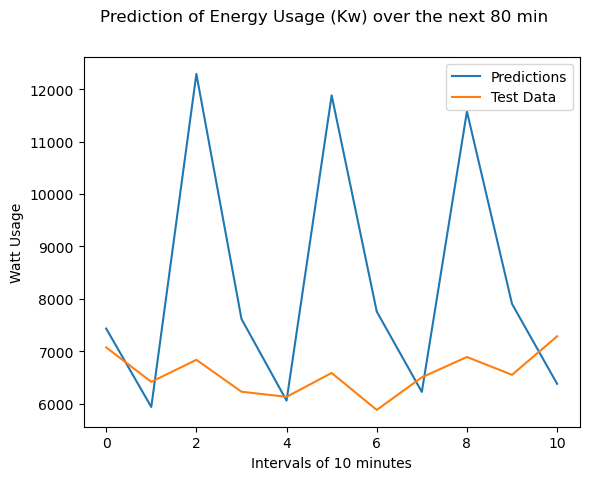

In [121]:
power_test = [i[0] for i in sc.inverse_transform(testNewY)]
plt.plot(predictions, label="Predictions")
plt.plot(power_test, label="Test Data")
plt.suptitle("Prediction of Energy Usage (Kw) over the next 80 min")
plt.xlabel("Intervals of 10 minutes")
plt.ylabel("Watt Usage")
plt.legend()
plt.show()